# Chapter 06: Logistic Regression

In [168]:
import math
import sympy
import scipy
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## Concepts

### Logistic Function

In [114]:
# The logistic function in python for one independent variable

def predict_probability(x, b0, b1):
    return 1 / (1 + math.exp(-(b0 + b1 * x)))

predict_probability(1, -2.823, 0.620)

0.09948141142901543

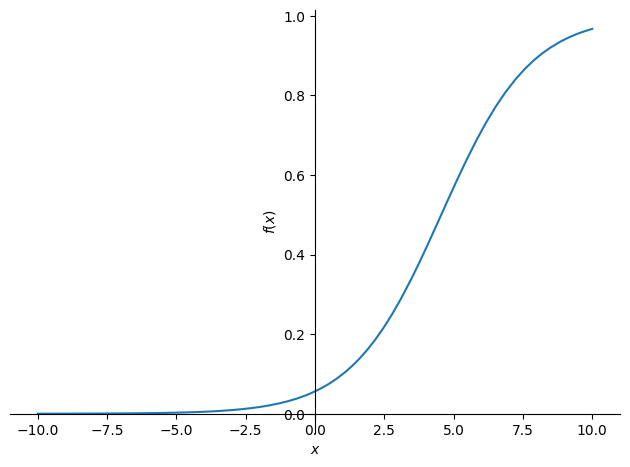

In [115]:
# Using sympy to plot a logistic function

b0, b1, x = sympy.symbols("bo b1 x")

p = 1 / (1 + sympy.exp(-(b0 + b1 * x)))

p = p.subs(b0, -2.823)
p = p.subs(b1, 0.620)

sympy.plot(p)

### Fitting Logistic Curve

In [116]:
# Using a plain logistic regression in scipy

df = pd.read_csv("https://bit.ly/33ebs2R", delimiter=",")

X = df.values[:, :-1]
Y = df.values[:, -1]

model = LogisticRegression(penalty=None)
model.fit(X, Y)

print(f"Coefficient: {model.coef_.flatten()[0]}")
print(f"Intercept: {model.intercept_[0]}")

Coefficient: 0.6926721243460743
Intercept: -3.1757639467271686


In [117]:
# Calculating the joint likelihood of observing all the points for a given logistic regression

patient_data = pd.read_csv("https://bit.ly/33ebs2R", delimiter=",").itertuples()

b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    return 1 / (1 + math.exp(-(b0 + b1 * x)))

joint_likelihood = 1.0

for p in patient_data:
    if p.y == 1:
        joint_likelihood *= logistic_function(p.x)
    elif p.y == 0:
        joint_likelihood *= (1 - logistic_function(p.x))
    else:
        raise ValueError("Class must be binary.")

print(joint_likelihood)

4.7911180221699105e-05


In [118]:
# Compressing the joint likelihood calculation without an if expression

patient_data = pd.read_csv("https://bit.ly/33ebs2R", delimiter=",").itertuples()

b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

joint_likelihood = 1.0

for p in patient_data:
    joint_likelihood *= logistic_function(p.x) ** p.y * \
    (1 - logistic_function(p.x)) ** (1 - p.y)

print(joint_likelihood)

4.7911180221699105e-05


In [119]:
# Calculating joint likelihood using logarithmic addition

patient_data = pd.read_csv("https://bit.ly/33ebs2R", delimiter=",").itertuples()

b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

joint_likelihood = 0.0

for p in patient_data:
    joint_likelihood += math.log(logistic_function(p.x) ** p.y * \
    (1.0 - logistic_function(p.x)) ** (1.0 - p.y))

joint_likelihood = math.exp(joint_likelihood)

print(joint_likelihood)

4.791118022169896e-05


In [121]:
# Using gradient descent on logistic regression

points = list(pd.read_csv("https://tinyurl.com/y2cocoo7").itertuples())

b1, b0, i, n = sympy.symbols("b1 b0 i n")
x, y = sympy.symbols("x y", cls=sympy.Function)

joint_likelihood = sympy.Sum(sympy.log((1.0 / (1.0 + sympy.exp(-(b0 + b1 * x(i)))))**y(i) * \
	(1.0 - (1.0 / (1.0 + sympy.exp(-(b0 + b1 * x(i))))))**(1-y(i))), (i, 0, n))

# Calculate partial derivatives
d_b1 = sympy.diff(joint_likelihood, b1) \
    .subs(n, len(points) -1).doit() \
    .replace(x, lambda i: points[i].x) \
    .replace(y, lambda i: points[i].y)

d_b0 = sympy.diff(joint_likelihood, b0) \
    .subs(n, len(points) -1).doit() \
    .replace(x, lambda i: points[i].x) \
    .replace(y, lambda i: points[i].y)

# compile using lambdify for faster computation
d_b1 = sympy.lambdify([b1, b0], d_b1)
d_b0 = sympy.lambdify([b1, b0], d_b0)

# Training
b1 = 0.01
b0 = 0.01
learning_rate = 0.01
iterations = 10000

for i in range(iterations):
    b1 += d_b1(b1, b0) * learning_rate
    b0 += d_b0(b1, b0) * learning_rate

print(f"Coefficient: {b1}")
print(f"Intercept: {b0}")

Coefficient: 0.6926693075370812
Intercept: -3.175751550409821


### Multivariable Logistic Regression

In [136]:
# Doing a multivariable logisitc regression on employee data

df = pd.read_csv("https://tinyurl.com/y6r7qjrp")

X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

model = LogisticRegression(penalty=None)
fit = model.fit(X, Y)

print(f"Coefficients: {model.coef_.flatten()}")
print(f"Intercept: {model.intercept_[0]}")

def predict_employee_will_stay(sex, age, promotions, years_employed):
    input_data = pd.DataFrame([[sex, age, promotions, years_employed]], columns=X.columns)
    prediction = fit.predict(input_data)
    probabilities = fit.predict_proba(input_data)
    if prediction == [[1]]:
        return "WILL LEAVE: {0}".format(round(probabilities[0][1],5))
    else:
        return "WILL STAY: {0}".format(round(probabilities[0][0], 5))

prediction_1 = predict_employee_will_stay(
    sex=1,
    age=30,
    promotions=6,
    years_employed=7
)
print(prediction_1)

Coefficients: [ 0.03213405  0.03682453 -2.50410028  0.9742266 ]
Intercept: -2.7348530152205615
WILL STAY: 0.99994


### R-Squared

In [139]:
# Calculating the log likelihood of the fit

patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",").itertuples()

b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

log_likelihood_fit = 0.0

for p in patient_data:
    if p.y == 1.0:
        log_likelihood_fit += math.log(logistic_function(p.x))
    elif p.y == 0.0:
        log_likelihood_fit += math.log(1.0 - logistic_function(p.x))
    else:
        raise ValueError("Class must be binary.")

print(log_likelihood_fit)

-9.946161673231583


In [140]:
# Consolidating our log likelihood to a single line

patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",").itertuples()

b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

log_likelihood_fit = sum(math.log(logistic_function(p.x)) * p.y +
                         math.log(1.0 - logistic_function(p.x)) * (1.0 - p.y)
                         for p in patient_data)

print(log_likelihood_fit)

-9.946161673231583


In [141]:
# Log likelihood of patients

patient_data = list(pd.read_csv('https://bit.ly/33ebs2R', delimiter=",") \
     .itertuples())

likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = 0

for p in patient_data:
    if p.y == 1.0:
        log_likelihood += math.log(likelihood)
    elif p.y == 0.0:
        log_likelihood += math.log(1.0 - likelihood)
    else:
        raise ValueError("Class must be binary.")

print(log_likelihood)

-14.341070198709906


In [144]:
# Consolidating the log likelihood into a single line

patient_data = list(pd.read_csv('https://bit.ly/33ebs2R', delimiter=",") \
     .itertuples())

likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = sum(math.log(likelihood)*p.y + math.log(1.0 - likelihood)*(1.0 - p.y) \
	for p in patient_data)

print(log_likelihood)

-14.341070198709906


In [145]:
# Calculating the r^2 for logistic regression

patient_data = list(pd.read_csv('https://bit.ly/33ebs2R', delimiter=",") \
                                .itertuples())

b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

# Calculate components for r^2 formula
log_likelihood_fit = sum(math.log(logistic_function(p.x)) * p.y +
                         math.log(1.0 - logistic_function(p.x)) * (1.0 - p.y)
                         for p in patient_data)

likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = sum(math.log(likelihood) * p.y + math.log(1.0 - likelihood) * (1.0 - p.y) \
	for p in patient_data)


r2 = (log_likelihood - log_likelihood_fit) / log_likelihood

print(f"r^2: {r2}")

r^2: 0.306456105756576


### P-Values

In [149]:
# Calculating a p-value for a given logistic regression

patient_data = list(pd.read_csv('https://bit.ly/33ebs2R', delimiter=",").itertuples())

b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

# Calculate chi-squared components
log_likelihood_fit = sum(math.log(logistic_function(p.x)) * p.y +
                         math.log(1.0 - logistic_function(p.x)) * (1.0 - p.y)
                         for p in patient_data)

likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = sum(math.log(likelihood) * p.y + math.log(1.0 - likelihood) * (1.0 - p.y) \
                     for p in patient_data)

# Calculate P-value
chi2_input = 2 * (log_likelihood_fit - log_likelihood)
p_value = scipy.stats.chi2.pdf(chi2_input, 1)

print(p_value)

0.0016604875618753787


### Train/Test Splits

In [174]:
# Performing logistic regression with a three-fold cross-validation

df = pd.read_csv("https://tinyurl.com/y6r7qjrp", delimiter=",")

X = df.values[:, :-1]
Y = df.values[:, -1]

kfold = KFold(n_splits=3, random_state=42, shuffle=True)
model = LogisticRegression(penalty=None)
results = cross_val_score(model, X, Y, cv=kfold)

print("Accuracy Mean: %.3f (stdev=%.3f)" % (results.mean(), results.std()))

Accuracy Mean: 0.667 (stdev=0.045)


### Confusion Matrices

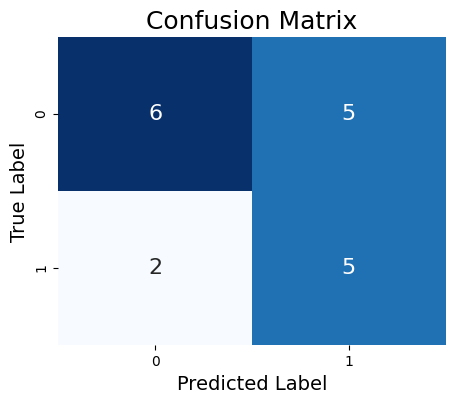

In [163]:
# Creating a confusion matrix for a testing dataset in scipy

df = pd.read_csv('https://bit.ly/3cManTi', delimiter=",")

X = df.values[:, :-1]
Y = df.values[:, -1]

model = LogisticRegression(solver='liblinear')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=42)
model.fit(X_train, Y_train)

prediction = model.predict(X_test)
matrix = confusion_matrix(y_true=Y_test, y_pred=prediction)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

### Reciever Operator Characteristic/Area Under Curve

In [175]:
# Using the AUC as the scikit-learn parameter

df = pd.read_csv("https://tinyurl.com/y6r7qjrp", delimiter=",")

X = df.values[:, :-1]
Y = df.values[:, -1]

kfold = KFold(n_splits=3, random_state=42, shuffle=True)
model = LogisticRegression(penalty=None)
results = cross_val_score(model, X, Y, cv=kfold, scoring="roc_auc")

print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.728 (0.106)


### Class Imbalance

In [169]:
# Using the stratify option in scikit-learn to balance classes in the data

df = pd.read_csv("https://bit.ly/33ebs2R", delimiter=",")

X = df.values[:, :-1]
Y = df.values[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42, stratify=Y)

model = LogisticRegression(penalty=None)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

print(f"Coefficient: {model.coef_.flatten()[0]}")
print(f"Intercept: {model.intercept_[0]}")
print(f"Accuracy: {accuracy:.3f}")

Coefficient: 0.5244050744725895
Intercept: -2.380441875689146
Accuracy: 0.857


## Code Exercises

In [195]:
# Exercise 6-1 (Perform logistic regression)

df = pd.read_csv("https://bit.ly/3imidqa", delimiter=",")

X = df.values[:, :-1]
Y = df.values[:, -1]

kfold = KFold(n_splits=3, random_state=0, shuffle=True)
model = LogisticRegression(penalty=None)
results = cross_val_score(model, X, Y, cv=kfold)

print("Accuracy Mean: %.3f (stdev=%.3f)" % (results.mean(), results.std()))

Accuracy Mean: 0.999 (stdev=0.002)


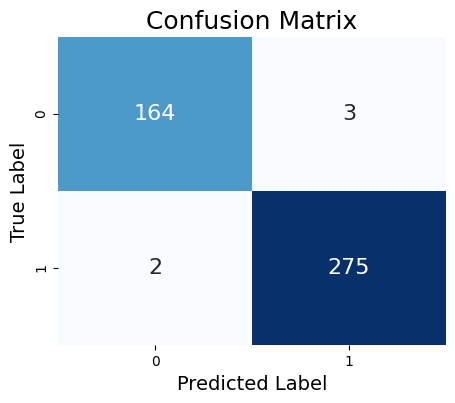

In [196]:
# Exercise 6-2 (Product a confision matrix)

df = pd.read_csv("https://bit.ly/3imidqa", delimiter=",")

X = df.values[:, :-1]
Y = df.values[:, -1]

model = LogisticRegression(solver='liblinear')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
model.fit(X_train, Y_train)

prediction = model.predict(X_test)
matrix = confusion_matrix(y_true=Y_test, y_pred=prediction)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

In [197]:
# Exercise 6-3 (Inference on new data points via trained model)

red = [[255, 0, 0]]
green = [[0, 255, 0]]
blue = [[0, 0, 255]]
yellow = [[255, 255, 0]]

def convert_prediction(pred):
    labels = {
        0: "light",
        1: "dark"
    }
    return labels[pred[0]]

red_background_prediction = model.predict(red)
green_background_prediction = model.predict(green)
blue_background_prediction = model.predict(blue)
yellow_background_prediction = model.predict(yellow)
print("Red background:", convert_prediction(red_background_prediction))
print("Green background:", convert_prediction(green_background_prediction))
print("Blue background:", convert_prediction(blue_background_prediction))
print("Yellow background:", convert_prediction(yellow_background_prediction))

Red background: light
Green background: dark
Blue background: light
Yellow background: dark


In [198]:
# Exercise 6-4 (Is logistic regression effective for this task?)

print("Logistic regression performs extremely well on this classification task. It has little error on our dataset when evaluated in a confusion matrix with a train/test split, and also on cross-valdiation.")

Logistic regression performs extremely well on this classification task. It has little error on our dataset when evaluated in a confusion matrix with a train/test split, and also on cross-valdiation.
